# Imports

In [1]:
import requests
import datetime
import time
import pandas as pd
import numpy as np
import json
import re
from pprint import pprint
import csv
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from textatistic import Textatistic
from textblob import TextBlob
from scipy import stats
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
%matplotlib inline
sns.set_style(style='darkgrid')
plt.rcParams["patch.force_edgecolor"]=True

# Load Sample Data

In [4]:
kiva = pd.read_pickle('kiva_423.pkl')

In [5]:
#Create subset that is just loans that received funding.
kiva = kiva[kiva['STATUS'] == 'funded']

In [6]:
kiva = kiva[kiva['BORROWERS_TOTAL'].isnull() ==False]
kiva = kiva[kiva['DAYS_TO_FUND'].isnull() == False]
kiva = kiva[kiva['LOAN_BOX'].isnull() == False]
kiva = kiva[kiva['FLESCH_SCORE'].isnull() == False]

# Initial visualization of the data

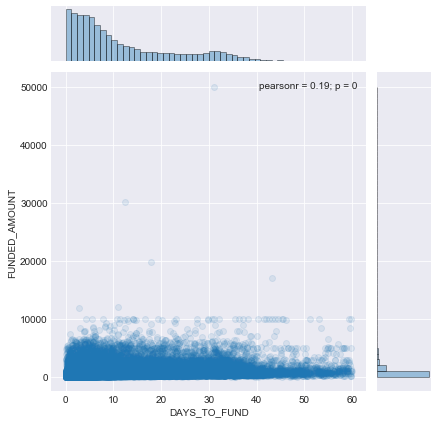

In [44]:
#viewing the correlation between days to funding and amount funded
sns.jointplot(x='DAYS_TO_FUND', y='FUNDED_AMOUNT', data=kiva, kind='scatter',alpha=.1)

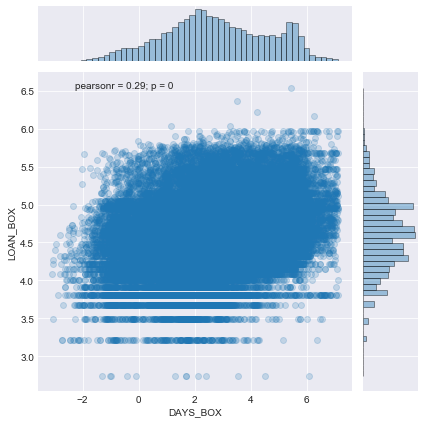

In [43]:
#Same plot as above but log transformed funded amount, and sqrt transformed days
sns.jointplot(x='DAYS_BOX', y='LOAN_BOX', data=kiva, kind='scatter', alpha=.2)

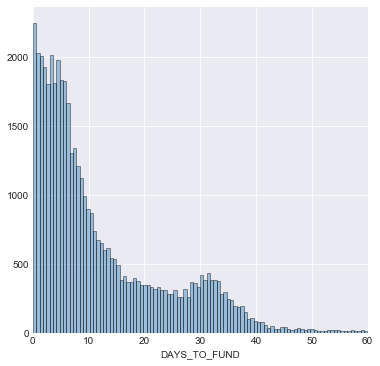

In [46]:
#plot of how long it takes projects to get funded
fig = plt.subplots(1,1, figsize=(6,6))
fig = plt.xlim(0, 60)
fig = plt.xlabel("Days to get funded")
sns.distplot(kiva['DAYS_TO_FUND'].dropna(), kde=False, bins = 100)

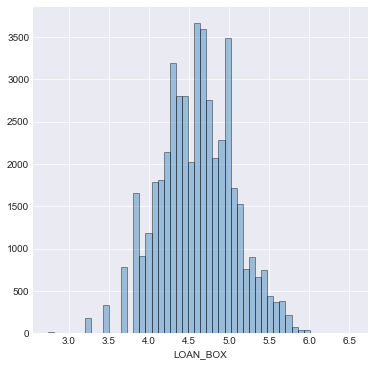

In [47]:
#plot of number of loans by size* size is scaled by log
fig = plt.subplots(1,1, figsize=(6,6))
fig = plt.xlim()
fig = plt.xlabel("Loan Size")
sns.distplot(kiva['LOAN_BOX'].dropna(), kde=False, bins = 50)

# Investigate Sample Data by Country

In [8]:
#find the 20 most frequent countries
df_country = kiva.COUNTRY_NAME.value_counts().nlargest(20).reset_index()
df_country.columns=['COUNTRY_NAME','count']

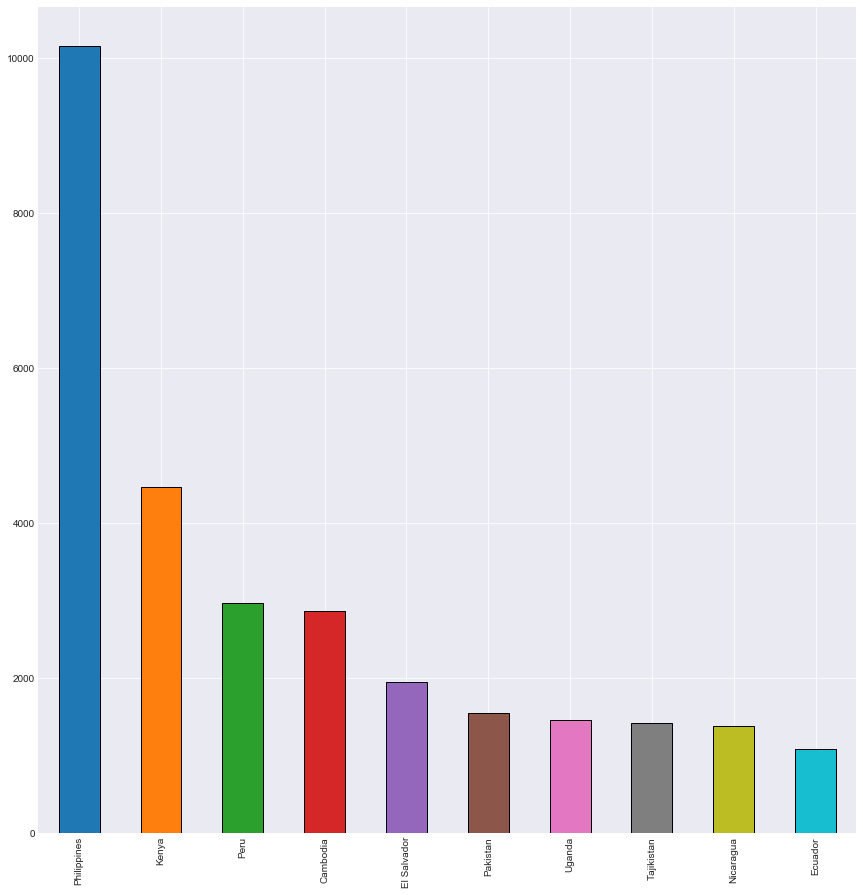

In [39]:
#Plot the 20 most frequent countries receiving loans
df_country = kiva.COUNTRY_NAME.value_counts().nlargest(10)
fig, axs = plt.subplots(1,1, figsize=(12,12))
f = plt.tight_layout()
df_country.plot.bar()

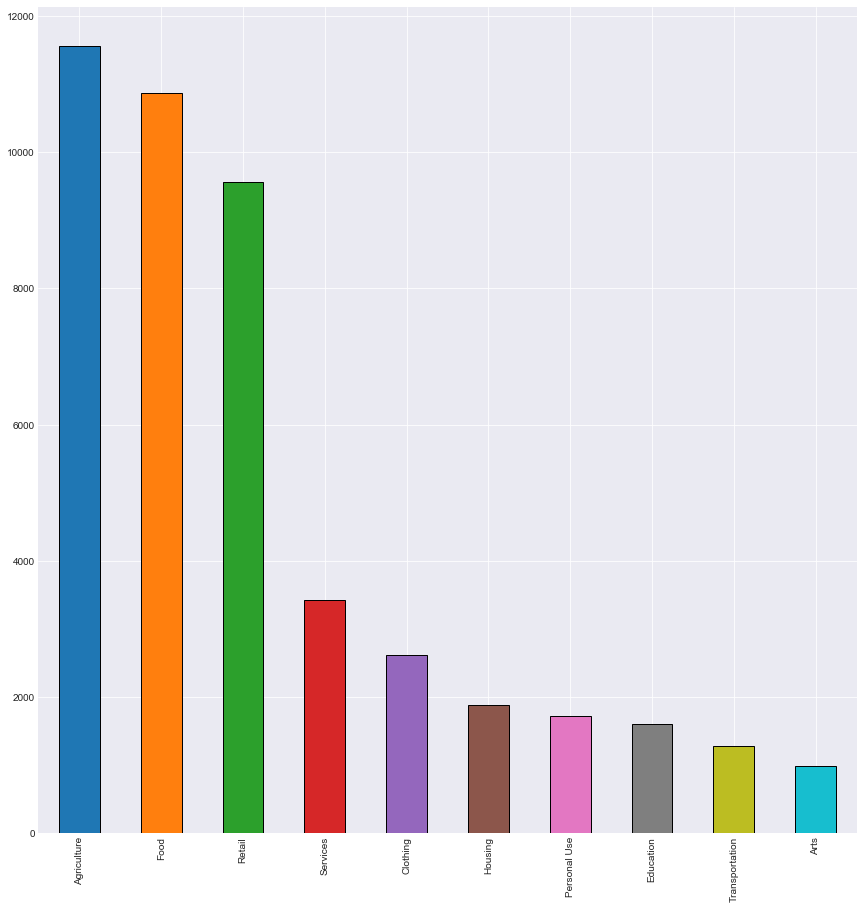

In [38]:
#plot the sectors receiving loans
df_sector = kiva.SECTOR_NAME.value_counts().nlargest(10)
fig, axs = plt.subplots(1,1, figsize=(12,12))
f = plt.tight_layout()
df_sector.plot.bar()

In [35]:
big_countries = kiva['COUNTRY_NAME'].value_counts().nlargest(5)
big_countries = big_countries.reset_index()
big_countries.columns=['COUNTRY_NAME', 'COUNT']
list_countries = big_countries['COUNTRY_NAME'].tolist()

In [36]:
big_sector = kiva['SECTOR_NAME'].value_counts().nlargest(5)
big_sector = big_sector.reset_index()
big_sector.columns=['SECTOR_NAME', 'COUNT']
list_sector = big_sector['SECTOR_NAME'].tolist()

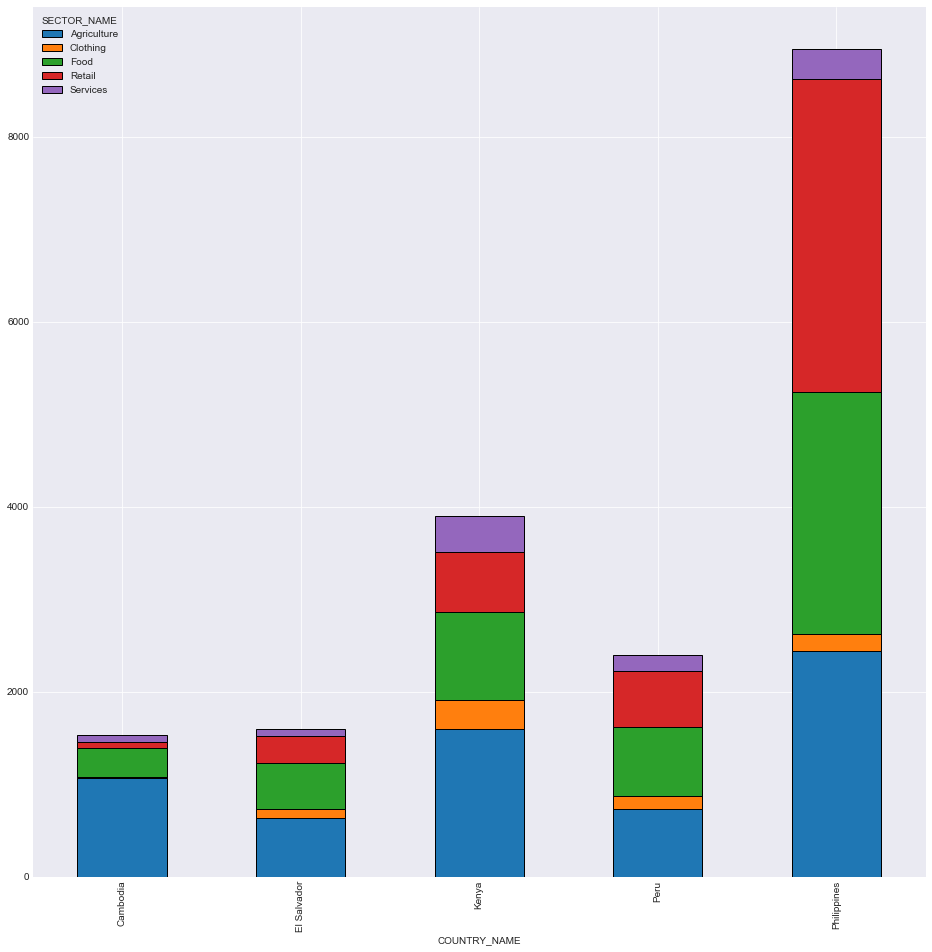

In [37]:
df_agg = kiva[(kiva['COUNTRY_NAME'].isin(list_countries)) & kiva['SECTOR_NAME'].isin(list_sector)].groupby(['COUNTRY_NAME'])['SECTOR_NAME'].value_counts().unstack()
df_agg.plot(kind='bar', stacked=True, figsize=(16,16))

# Further investigation into Kenya and Philippines

In [49]:
Kiva_Phil = kiva[kiva['COUNTRY_NAME']=='Philippines']
Kiva_Kenya = kiva[kiva['COUNTRY_NAME']=='Kenya']

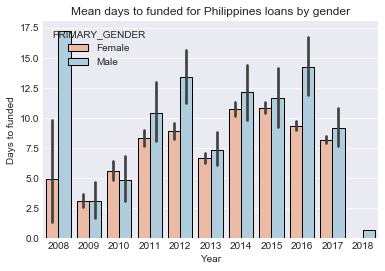

In [50]:
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Phil, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Philippines loans by gender')
plt.savefig('philippines_gender.png', dpi=300)

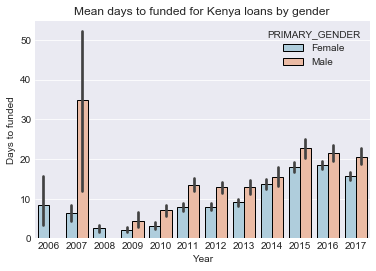

In [51]:
ax.legend(['Males', 'Females'])
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Kenya, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu_r')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Kenya loans by gender')
#ax.legend(loc='upper left')
#ax.get_legend_handles_labels(labels['Males', 'Females'])
plt.savefig('kenya_gender.png', dpi=300)

# Further exploration of Kenya

In [52]:
Kiva_CV = Kiva_Kenya.drop(['ORIGINAL_LANGUAGE', 'DESCRIPTION_TRANSLATED', 'FUNDED_AMOUNT', 'STATUS', 'IMAGE_ID',
                           'TOWN_NAME','CURRENCY_POLICY','POSTED_TIME',
                           'PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME','LENDER_TERM',
                           'TAGS','BORROWER_GENDERS','REPAYMENT_INTERVAL','DISTRIBUTION_MODEL',
                           'TIME_DELTA','FEMALE_BORROWERS','MALE_BORROWERS','YEAR','PERCENT_FEMALE',
                           'PRIMARY_GENDER', 'COUNTRY_NAME'],
                          axis=1)

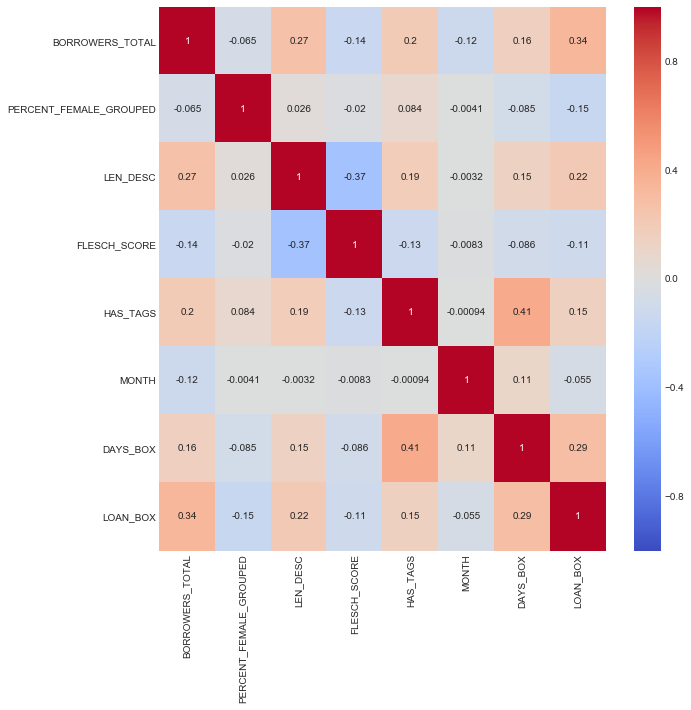

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Kiva_CV.drop(['LOAN_AMOUNT','DAYS_TO_FUND'],1).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax)

In [74]:
#Create X and y variables to 
y = Kiva_CV.dropna()['DAYS_BOX']
X = Kiva_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
#Create a dummy variable of SECTOR_NAME
Dummy = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X = X.join(Dummy)

In [75]:
#Make the train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [76]:
#Run initial LinearRegression model
model= LinearRegression()
model.fit(X,y)
print('Linear Regression on entire dataset',model.score(X,y))

model.fit(X_train,y_train)
print('Train/Test/Split training', model.score(X_train,y_train))
print('Train/Test/Split testing', model.score(X_test,y_test))
reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
print('10 Fold Cross Validation', np.mean(scores))

Linear Regression on entire dataset 0.27933654341299263
Train/Test/Split training 0.2767992269242058
Train/Test/Split testing 0.278767569432104
10 Fold Cross Validation 0.2701029782135722


In [82]:
#create a 2 degree polynomial and run linear regression on training data.
degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train,y_train)
print ('2nd degree polynomial with linear regression training r^2', est.score(X_train,y_train))
print ('2nd degree polynomial with linear regression test r^2', est.score(X_test,y_test))

2nd degree polynomial with linear regression training r^2 0.36042599221724725
2nd degree polynomial with linear regression test r^2 0.30446558161583626


In [ ]:
degree = 3
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
α = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
est = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas=α))
est.fit(X,y)
print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      est.named_steps.elasticnetcv.l1_ratio_)

In [ ]:
coef_df = pd.DataFrame()
poly = est.steps[0][1]
coef_df['feature'] = poly.get_feature_names(X.columns)
coef_df['coefficient'] = est.steps[-1][1].coef_.ravel()
coef_df[coef_df['coefficient'] != 0].sort_values('coefficient')